In [1]:
%matplotlib inline
import pandas as pd
import pickle
import plotly.express as px
from tqdm import tqdm
import csv

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_colwidth", None) # None for all of it
PARTYCOLORS =  {'AfD': '#59dcff', "CSU":"#525060", "CDU":"black", "CDU/CSU":"black","SPD":"#e03427", "GRÜNE":"#52d157", "DIE LINKE":"#a33ab5", "FDP":"#ffeb3b",}

# Imports for BERTopic

from bertopic.representation import MaximalMarginalRelevance
from umap import UMAP
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

In [2]:
BUNDESLAND = "nrw"

In [3]:
# Import selected sentences and select electoral period 19
stc = pd.read_feather(f"data/{BUNDESLAND}_climate.feather")
stc = stc[stc["electoral_term"] == sorted(list(stc["electoral_term"].unique()))[1]]
stc = stc.reset_index()
stc.shape

(4539, 14)

In [4]:
stc[stc["sentence"].str.contains(r"CO2\w")]

,index,sent_id,speech_id,name,electoral_term,party,role,date,session,sentence_no,sentence_length,sentence,issue,issue_total_speeches


In [5]:
from sentence_transformers import SentenceTransformer

## Prepare embeddings
# Small sentence transformer
# sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Large sentence transformer
sentence_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

In [6]:
## Only needs to be done once
#speeches = stc["sentence"].to_list()
#embeddings = sentence_model.encode(speeches)

#with open(f'data/topic_modeling/mpnet-base-v2_{BUNDESLAND}.pickle', 'wb') as pkl:
#    pickle.dump(embeddings, pkl)

In [7]:
# Load embeddings from pickle
speeches = stc["sentence"].to_list()
with open(f'data/topic_modeling/mpnet-base-v2_{BUNDESLAND}.pickle', 'rb') as pkl:
    embeddings = pickle.load(pkl)
len(speeches)

4539

In [8]:
# Count documents of each party in each topic
def count_topic_by_party(dftm):
    dfcount = pd.DataFrame(dftm.groupby(["party", "Topic"])["Document"].count()).reset_index()
    missing_count = []
    
    for party in dftm.party.unique().tolist():
        for i in range(max(topic_model.topic_sizes_.keys())+1):
            if len(dfcount[(dfcount["party"] == party) & (dfcount["Topic"] == i)]) == 0:
                missing_count.append([party, i, 0])
    
    missingdf = pd.DataFrame(missing_count, columns=['party','Topic','Document'])
    dfcount = pd.concat([dfcount, missingdf]).reset_index()
    return dfcount

In [9]:
def fit_model(params):
    umap_model = UMAP(n_neighbors=params["umap_n_neigh"], n_components=params["umap_n_comp"], metric='cosine', random_state=params["random_state"], low_memory=False)
    
    # Create representation model
    representation_model = MaximalMarginalRelevance(diversity=0.15, top_n_words=15)
    
    # Vectorizer to remove german stop words from representation
    german_stop_words = stopwords.words('german')
    vectorizer_model = CountVectorizer(stop_words = german_stop_words)
    
    topic_model = BERTopic(representation_model=representation_model, vectorizer_model=vectorizer_model, umap_model=umap_model, 
                           embedding_model=sentence_model, top_n_words=12, min_topic_size=params["min_topic_size"])

    topics, probs = topic_model.fit_transform(speeches, embeddings)
    
    return topic_model, topics, probs

In [10]:
def results_summary(stc, speeches, topics, outlier_reduced=False):
    # Results as dataframe
    dftm = pd.DataFrame({"Document": speeches, "Topic": topics})
    dftm = dftm.join(stc.party).join(stc.session).join(stc.speech_id).join(stc.sent_id)
    #dftm.sample()
    
    dfcount = count_topic_by_party(dftm)
    
    dfcount["total"] = dftm.party.value_counts()[dfcount["party"]].reset_index()["count"]
    dfcount["topic_salience"] = dfcount["Document"] / dfcount["total"]
    dfcount["salience_sum"] = dfcount.Topic.map(dfcount.groupby("Topic").topic_salience.sum())
    dfcount["salience_normalized"] = dfcount["topic_salience"] / dfcount["salience_sum"]
    dfcount["std_sal_normalized"] = dfcount.Topic.map(dfcount.groupby("Topic")["salience_normalized"].std())
    dfcount.loc[:,"mean_normalized"] = dfcount.Topic.map(dfcount.groupby("Topic").salience_normalized.mean())
    dfcount.loc[:,"sal_diff"] = abs(dfcount["salience_normalized"] - dfcount["mean_normalized"])
    
    #percentage of outliers
    percentage_outlier = dfcount[dfcount["Topic"] == -1]["Document"].sum()/len(speeches)
    
    # Mean std deviation of normalized topic salience 
    import statistics
    sal_std = statistics.mean(dfcount[(dfcount["Topic"]>-1)].groupby("Topic")["salience_normalized"].std())

    params["num_topics"] = dftm.Topic.nunique()
    params["perc_outlier"] = f"{(percentage_outlier):.4f}"
    params["max_topic_count"] = dftm[dftm["Topic"]>-1].Topic.value_counts().max()
    params["sal_std"] = f"{(sal_std):.4f}"
    params["top_sal_diff"] = dfcount.sort_values("sal_diff").tail(20).sal_diff.mean()
    params["high_sal_diff_perc_of_topic"] = f"{(dfcount[dfcount["sal_diff"] > 0.2].party.value_counts().sum() / params["num_topics"]):.4f}"
    params["top_party_high_sal_diff"] = dfcount.sort_values("sal_diff").tail(20).party.value_counts().max()
    params["outlier_reduced"] = outlier_reduced
    
    ## Only needed for hyperparameter tuning
    #with open(f"data/topic_modeling/bertopic_params_{BUNDESLAND}.csv", "a", newline="") as f:
    #    w = csv.DictWriter(f, params.keys())
    #    w.writerow(params)

    return dftm, dfcount

In [12]:
# Hyperparameter tuning
for n in tqdm([3,4]):#5,6,7,8,9
    for s in [10,12,15]:
        for rs in [2,18,42,41,43,45,99]:
            params = {"umap_n_neigh":n, "umap_n_comp": 5, "min_topic_size":s, "random_state": rs}
            # Do the modelling
            topic_model, topics, probs = fit_model(params)
            results_summary(stc, speeches, topics)
            
            # testing outlier reduction at different threshholds
            for thr in [0.75,0.7]:
                try:
                    tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=thr)
                    dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)
                except:
                    pass

  0%|                                                                                                                                                                                    | 0/2 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [26]:
# Evaluation of parameter tuning
hp = pd.read_csv(f"data/topic_modeling/bertopic_params_{BUNDESLAND}.csv", header=None)
hp = hp.set_axis(params.keys(), axis=1)
hp = hp[hp["outlier_reduced"]]

In [27]:
hp.groupby(["umap_n_neigh", "min_topic_size"]).num_topics.std()

umap_n_neigh  min_topic_size
3             10                 8.299345
              12                26.658607
              15                19.552128
4             10                 5.195095
              12                29.778671
              15                18.881935
5             10                26.339291
              12                21.128754
              15                19.225141
6             10                22.947623
              12                27.499451
              15                19.060139
7             10                28.741363
              12                20.989793
              15                12.068931
8             10                31.372978
              12                23.273812
              15                18.138357
9             10                28.752831
              12                19.907478
              15                14.963876
Name: num_topics, dtype: float64

In [21]:
hp

,umap_n_neigh,umap_n_comp,min_topic_size,random_state,num_topics,perc_outlier,max_topic_count,sal_std,top_sal_diff,high_sal_diff_perc_of_topic,top_party_high_sal_diff,outlier_reduced
0,5,5,10,2,77,0.3948,177,0.1595,0.466288,0.4416,7,False
3,5,5,10,18,66,0.2833,717,0.1487,0.391511,0.4091,6,False
6,5,5,10,42,78,0.3587,243,0.1569,0.459790,0.4359,10,False
9,5,5,10,41,80,0.3922,193,0.1592,0.442347,0.4500,8,False
12,5,5,10,43,4,0.0013,4418,0.1669,0.125166,0.7500,4,False
15,5,5,10,45,78,0.3703,238,0.1521,0.431477,0.4615,9,False
18,5,5,10,99,74,0.3985,233,0.1455,0.410124,0.3919,6,False
21,5,5,12,2,65,0.3968,248,0.1552,0.429139,0.4308,7,False
24,5,5,12,18,54,0.2917,718,0.1320,0.296601,0.2963,7,False
27,5,5,12,42,3,0.0000,4434,0.1706,0.129191,0.6667,3,False


In [28]:
hp = hp[hp["umap_n_neigh"] == 4]
hp = hp[hp["min_topic_size"] == 10]
hp

,umap_n_neigh,umap_n_comp,min_topic_size,random_state,num_topics,perc_outlier,max_topic_count,sal_std,top_sal_diff,high_sal_diff_perc_of_topic,top_party_high_sal_diff,outlier_reduced
367,4,5,10,2,87,0.1527,273,0.1437,0.431798,0.3793,9,True
368,4,5,10,2,87,0.0853,276,0.1395,0.423533,0.3333,9,True
370,4,5,10,18,88,0.1447,257,0.1449,0.418116,0.4091,8,True
371,4,5,10,18,88,0.0784,274,0.1425,0.409072,0.4318,10,True
373,4,5,10,42,77,0.1423,259,0.1435,0.408359,0.4026,9,True
374,4,5,10,42,77,0.0809,261,0.1386,0.395581,0.4026,9,True
376,4,5,10,41,74,0.1236,699,0.1348,0.378708,0.3108,7,True
377,4,5,10,41,74,0.0681,701,0.1332,0.364819,0.3108,9,True
379,4,5,10,43,79,0.1474,240,0.1425,0.402724,0.4177,6,True
380,4,5,10,43,79,0.0817,242,0.1386,0.390285,0.3924,6,True


In [30]:
hp.groupby(["umap_n_neigh", "min_topic_size"]).mean()

,,umap_n_comp,random_state,num_topics,perc_outlier,max_topic_count,sal_std,top_sal_diff,high_sal_diff_perc_of_topic,top_party_high_sal_diff,outlier_reduced
umap_n_neigh,min_topic_size,,,,,,,,,,
4,10,5.0,41.428571,81.714286,0.112143,316.857143,0.142243,0.411087,0.393471,8.285714,1.0


In [11]:
params = {"umap_n_neigh":4, "umap_n_comp": 5, "min_topic_size":10, "random_state": 99}

# Do the modelling
topic_model, topics, probs = fit_model(params)
dftm, dfcount = results_summary(stc, speeches, topics)

tps = topic_model.reduce_outliers(speeches, topics , strategy="embeddings", embeddings=embeddings, threshold=0.7)
dftm, dfcount = results_summary(stc, speeches, tps, outlier_reduced=True)

# Overview Topics

In [14]:
print("Number of sentences:", dfcount.Document.sum())
print("Number of Topics:", dfcount["Topic"].max())
print("Size smallest and biggest Topic:", dftm[dftm["Topic"]>-1].Topic.value_counts().min(), dftm[dftm["Topic"]>-1].Topic.value_counts().max())
print("% outlier", dfcount[dfcount["Topic"] == -1]["Document"].sum()/dfcount["Document"].sum())

Number of sentences: 4539
Number of Topics: 79
Size smallest and biggest Topic: 11 232
% outlier 0.08680326063009473


In [12]:
# Save all topic representations to table
topic_model.get_topic_info()[["Topic", "Count", "Representation", "Representative_Docs"]].to_csv(f"overview_topics_{BUNDESLAND}_{sorted(list(stc["electoral_term"].unique()))[-1]}.csv", index=False)

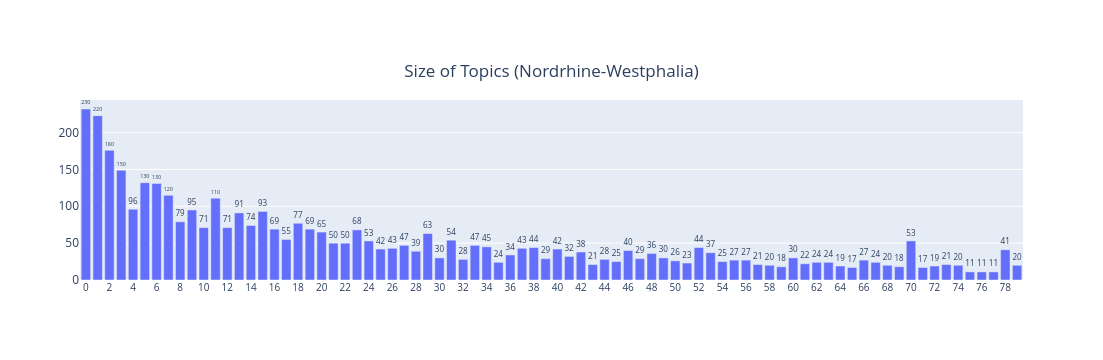

In [21]:
fig = px.bar(dftm[~(dftm["Topic"]==-1)].Topic.value_counts(), title="Size of Topics (Nordrhine-Westphalia)", text_auto='.2s')
fig.update_layout(title_x=0.5, title_y=0.82, showlegend=False, xaxis_title=None, yaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(0, dfcount["Topic"].nunique(), 2))))
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_xaxes(tickangle=0)
fig.show()

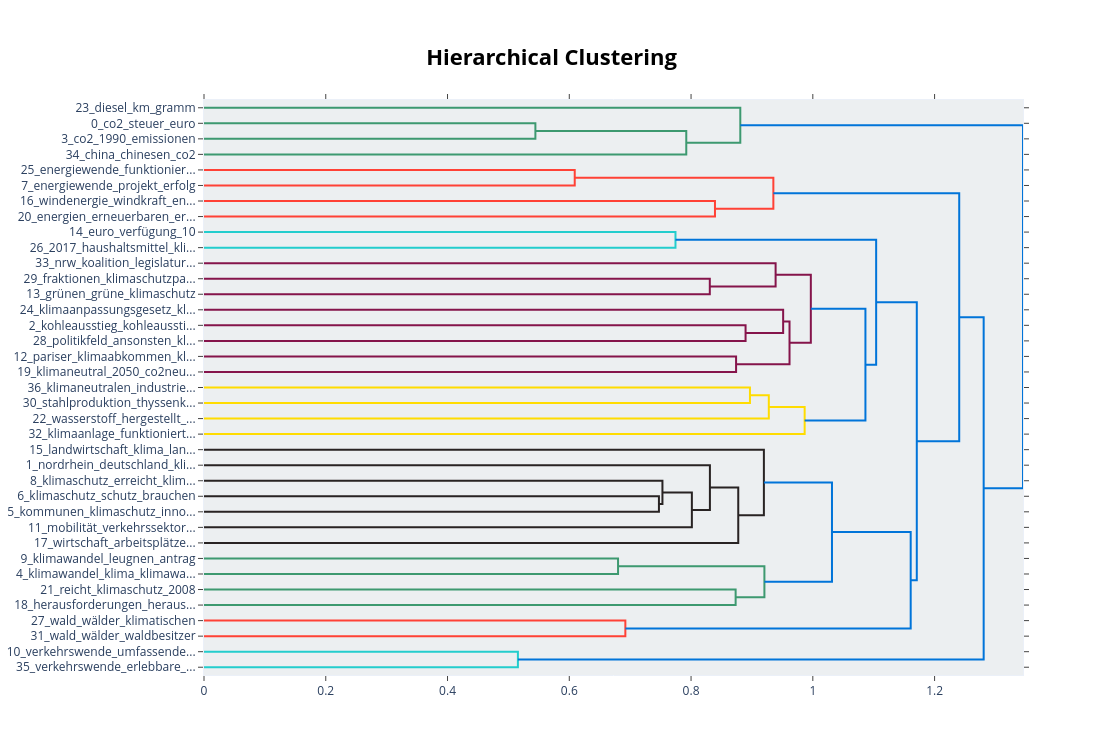

In [38]:
topic_model.visualize_hierarchy()

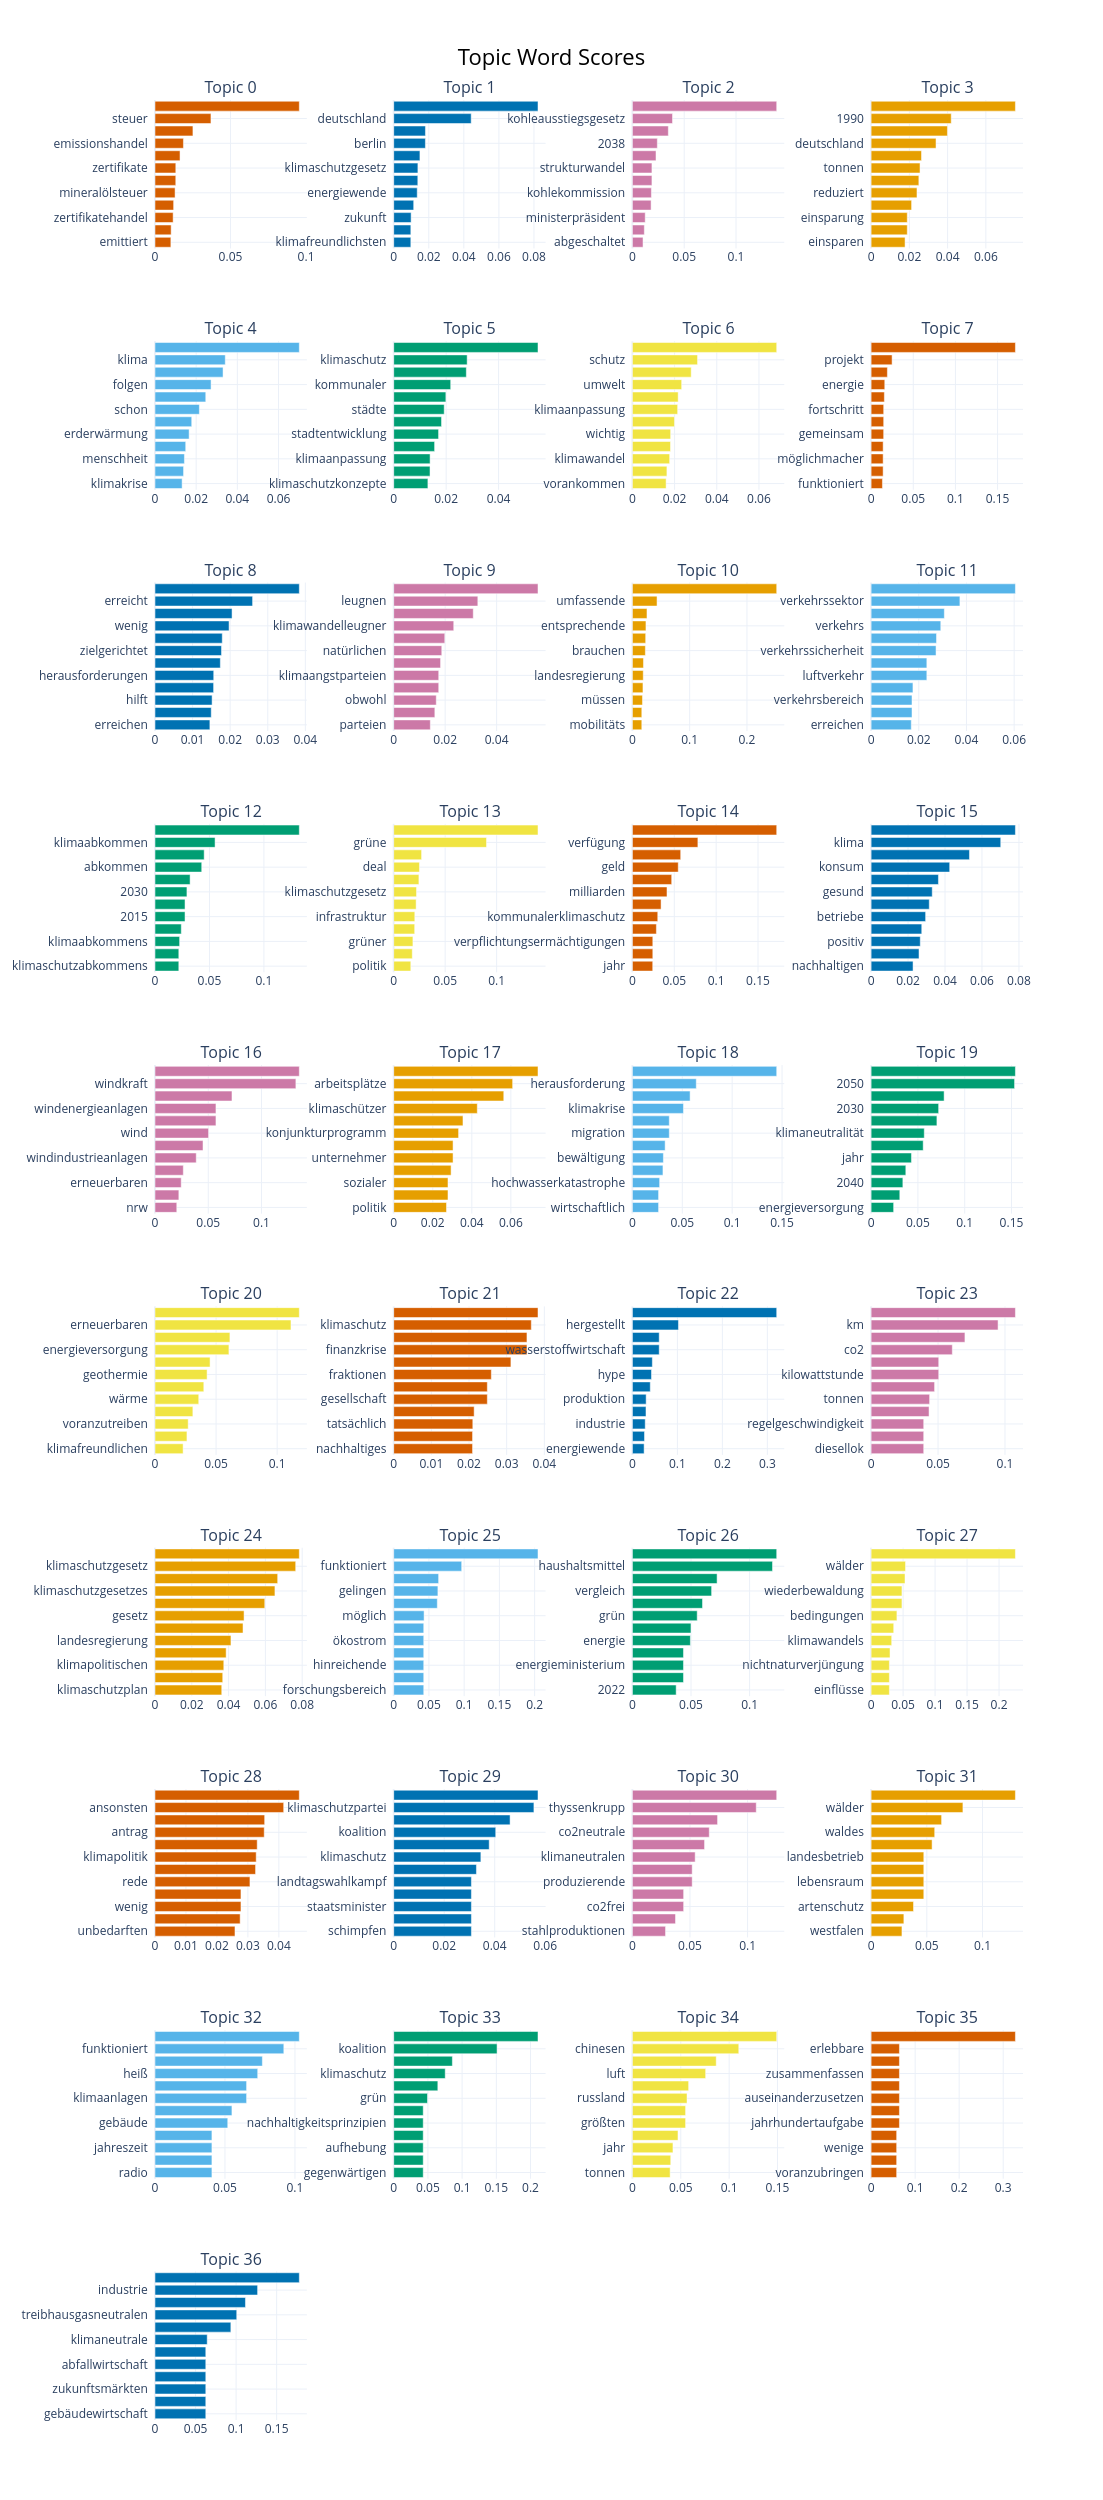

In [39]:
topic_model.visualize_barchart(top_n_topics = 87, n_words = 15)

# Topic salience Party Comparison

In [40]:
dfcount[dfcount["Topic"] == 3]

,index,party,Topic,Document,total,topic_salience,salience_sum,salience_normalized,std_sal_normalized,mean_normalized,sal_diff
4,4,AfD,3,33,986,0.033469,0.16831,0.198851,0.05987,0.2,0.001149
81,81,CDU,3,39,826,0.047215,0.16831,0.280527,0.05987,0.2,0.080527
156,156,FDP,3,26,713,0.036466,0.16831,0.216658,0.05987,0.2,0.016658
228,228,GRÜNE,3,20,1047,0.019102,0.16831,0.113494,0.05987,0.2,0.086506
308,308,SPD,3,31,967,0.032058,0.16831,0.190470,0.05987,0.2,0.009530


In [20]:
# Salience not normalized
graphdf1 = dfcount[(dfcount.Topic < 25) & (dfcount["Topic"] > 0) ]
graphdf2 = dfcount[(dfcount.Topic >= 28) & (dfcount.Topic < 55)]
graphdf3 = dfcount[(dfcount.Topic >= 55) ]
#fig = px.bar(graphdf1, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()
#fig = px.bar(graphdf2, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()
#fig = px.bar(graphdf3, x="Topic", y="topic_salience", color="party", barmode='group', color_discrete_map=PARTYCOLORS, title="Topic salience")
#fig.show()

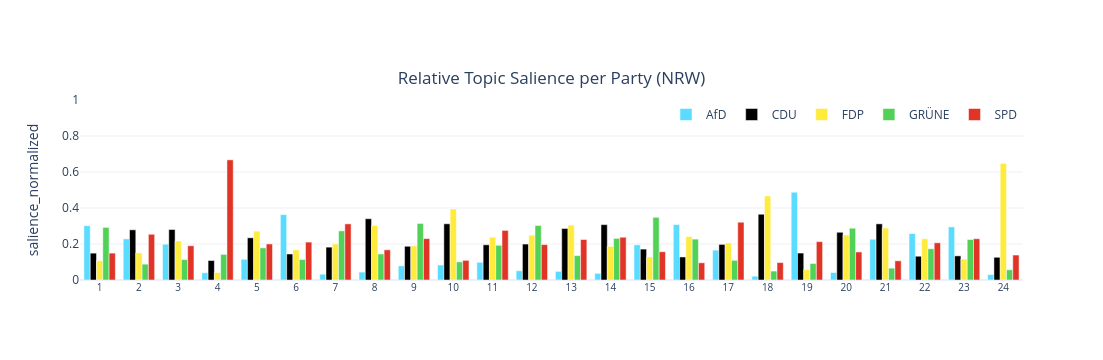

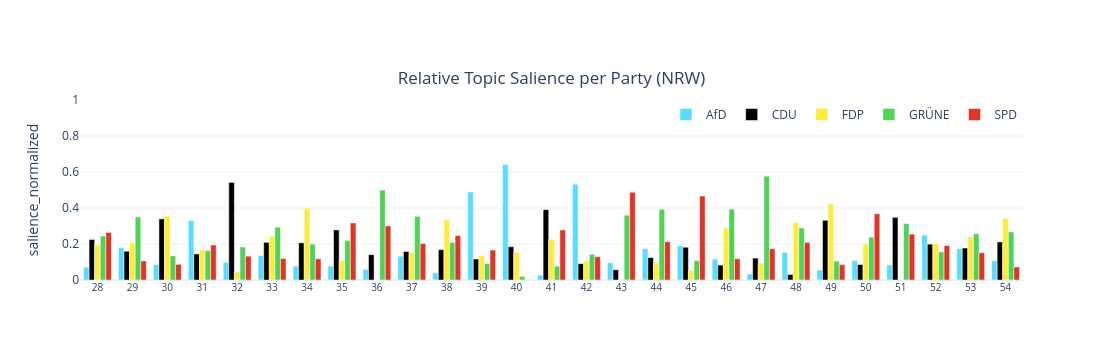

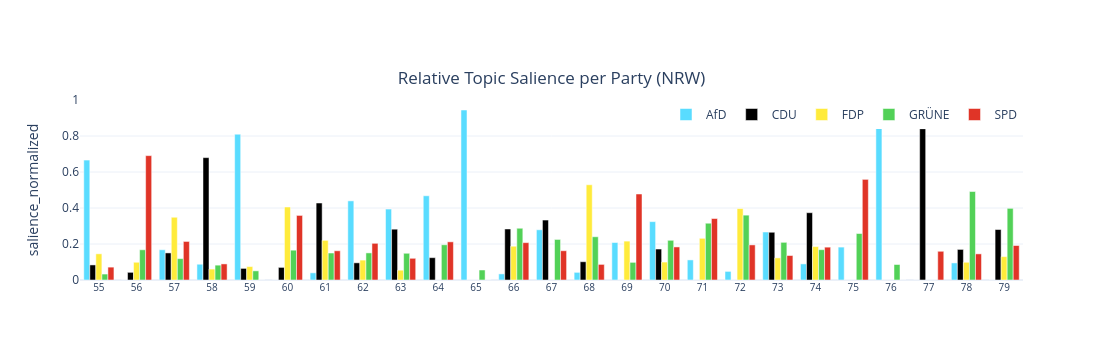

In [21]:
# Salience normalized
fig = px.bar(graphdf1, x="Topic", y="salience_normalized", color="party", range_y=[0,1], barmode='group', template="plotly_white", color_discrete_map=PARTYCOLORS, title=f"Relative Topic Salience per Party ({BUNDESLAND.upper()})").update_layout(title_x=0.5, title_y=0.8, legend=dict(yanchor="top", y=1, xanchor="right", x=1, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(-1, graphdf1["Topic"].nunique()+1))))
fig.show()
fig = px.bar(graphdf2, x="Topic", y="salience_normalized", color="party", range_y=[0,1], barmode='group', template="plotly_white", color_discrete_map=PARTYCOLORS, title=f"Relative Topic Salience per Party ({BUNDESLAND.upper()})").update_layout(title_x=0.5, title_y=0.8, legend=dict(yanchor="top", y=1, xanchor="right", x=1, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(graphdf2["Topic"].unique().min(), graphdf2["Topic"].unique().max()+1))))
fig.show()
fig = px.bar(graphdf3, x="Topic", y="salience_normalized", color="party", range_y=[0,1], barmode='group', template="plotly_white", color_discrete_map=PARTYCOLORS, title=f"Relative Topic Salience per Party ({BUNDESLAND.upper()})").update_layout(title_x=0.5, title_y=0.8, legend=dict(yanchor="top", y=1, xanchor="right", x=1, orientation='h', title=""), xaxis_title=None)
fig.update_layout(xaxis=dict(tickfont_size=10, tickvals=list(range(graphdf3["Topic"].unique().min(), graphdf3["Topic"].unique().max()+1))))
fig.show()

# Detailed Topic inspection

In [41]:
selection_high = dfcount[dfcount["salience_normalized"] > 0.45]
topicsh = selection_high.Topic.unique()
info = topic_model.get_topic_info()
info = info[info["Topic"].isin(topicsh)]
info = pd.merge(info, selection_high[["Topic","party", "salience_normalized"]])
info.head(1)

,Topic,Count,Name,Representation,Representative_Docs,party,salience_normalized
0,4,94,4_verkehrswende_umfassende_städten_nahverkehr,"[verkehrswende, umfassende, städten, nahverkehr, debatte, brauchen, mobilitäts, breiter, weshalb, verdoppelung, weitestgehend, braucht]","[Die Frage ist also nicht, ob wir die Verkehrswende machen, sondern es geht darum, dass wir sie endlich machen., Es ist ein Beitrag zu einer umfassenden Verkehrswende., Das ist für eine umfassende Verkehrswende notwendig.]",SPD,0.667476


In [47]:
selection_high.party.value_counts()

party
AfD      9
SPD      6
CDU      3
FDP      3
GRÜNE    3
Name: count, dtype: int64

In [45]:
info[info["party"] == "AfD"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
17,65,12,0.944413,"[china, chinesen, usa, russland, abkommen, kohlekraftwerkskapazitäten, braunkohlekraftwerk, photovoltaikanlage, milliarden, co2, erzeugten, ausweiten]","[China und Indien mit zusammen 35 % des menschengemachten CO2-Ausstoßes machen nicht mit., Die Hauptquellen für die 5 % verbleibenden, von Menschen erzeugten CO2 Emissionen bilden China, die USA, Indien und Russland mit einem Anteil von zusammen deutlich mehr als 50 % dieser Emissionen., Die größten Emittenten wie China, Indien, Russland und USA machen da nicht mit – immerhin 55 % des menschengemachten CO2 .]"
21,76,11,0.913932,"[eigenheim, nichtversteher, energiewendepolitik, kohleausstiegsfantastereien, parlaments, solaranlage, fabrik, oberschichtenwähler, herum, arbeitslosen, wähler, nützt]","[Aber die 9.000 Arbeitslosen bei STEAG und die 1.800 bei Continental sind für Sie wahrscheinlich einfach nur Energiewende-Nichtversteher., Die Oberschichtenwähler interessieren sich sowieso nicht für die Malocher in der Fabrik, die aufgrund Ihrer Klimapolitik ihre Arbeitsplätze verlieren, Wähler wie zum Beispiel eine Lehrerin, die sich eine Solaranlage auf ihr Eigenheim packt und in der Garage ihr Elektroauto auflädt., Wir hauen das Geld in Deutschland einfach für die Energiewende raus – ganz egal, ob es etwas nützt oder nicht.]"
15,59,15,0.810008,"[pflanzen, lebensgrundlage, pflanzenwachstum, wachsen, co2, stoffwechsel, optimum, lebenselixier, ppm, nahrungsmittelgewinn, experimente, minimum]","[Sie ignorieren völlig, dass CO2 eine Lebensgrundlage für Pflanzen und Bäume darstellt., Der optimale CO2-Anteil bei den sogenannten C3-Pflanzen – dazu zählen Getreide, Kartoffeln und alle Baumarten – liegt sogar bei 800 bis 1.600 ppm und damit beim Doppelten bis Vierfachen der aktuellen CO2 Konzentration, die erdgeschichtlich immer noch auf einem extremen Minimum ist., CO2 ist die Lebensgrundlage aller Bäume und Pflanzen auf der Welt.]"
12,55,15,0.666267,"[umweltbundesamt, wissenschaftler, aussagen, glauben, leugnen, 1882, statistischen, meteorologischen, fragezeichen, leugnende, klimatologische, klimatologen]","[Befürchtet man also, dass das eigene naturwissenschaftliche Projekt keine Förderung erfahren wird, hängt man „in Zeiten der Klimakrise“ oder „unter Genderaspekten“ an den Titel der ursprünglichen Forschungshypothese an und hofft darauf, noch in dieses oder jenes Förderpaket hineinrutschen zu können., Wenn Sie schon den Klimatologen nicht glauben, glauben Sie vielleicht dem Umweltbundesamt, laut dem es bisher eben nicht möglich ist – Zitat –, „statistisch gesicherte klimatologische Aussagen über Änderungen von Starkniederschlagsereignissen zu treffen.“, Ginger Spice und der 1882 verstorbene Naturwissenschaftler Darwin sollen die 1999 verfasste und den Klimawandel leugnende Oregon-Petition unterschrieben haben, die die AfD hier als Kronzeuge für ihre Klimaleugnertheorie anführt.]"
7,40,21,0.641421,"[deutschland, co2, eingespartes, günstiger, zertifikate, euweiten, zertifikatehandel, länder, deutsche, einsparungen, reduziert, einsparung]","[Alles, was wir in Deutschland an CO2 sparen, können dann Länder wie Polen oder Frankreich mehr in die Luft pusten., Zudem gibt es einen EUweiten Zertifikatehandel, sodass in Deutschland eingespartes CO2 einfach in Polen zusätzlich in die Luft geblasen werden kann., Zudem gibt es einen EUweiten Zertifikatehandel, sodass in Deutschland eingespartes CO2 einfach in Polen zusätzlich in die Luft gepustet werden kann.]"
8,42,20,0.531936,"[klimaaktivisten, parteien, anfrage, beiden, politiker, fremde, kandidatin, hindeutet, klimaumweltpolitik, absurd, nahezustehen, kohlegegner]","[Aber, Herr Pinkwart und die Kollegen von FDP und CDU, Ihren Anspruch, den Sie hier heute formuliert haben, nun die allergrößten Vorreiter beim Klimaschutz in NRW zu sein – beim besten Willen, Herr Pinkwart, die Fakten sprechen dagegen –, können Sie nicht erfüllen, allen Bekenntnissen und allem Selb

In [46]:
info[info["party"] == "SPD"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
13,56,15,0.690880,"[sozialdemokraten, sozialdemokratinnen, soziale, klimapolitik, akzeptanz, sozialen, normen, christlichen, aktivistin, südorganisation, sozialverträglichkeit, sklavenarbeit]","[Klimapolitik ist für uns Sozialdemokratinnen und Sozialdemokraten eine Politik für viele., Wir müssen in der Umwelt- und Klimapolitik immer die soziale Frage – das ist für Sozialdemokraten klar – im Blick behalten., Die Aktivistin der ‚Christlichen Initiative Romero‘, einer Nord-SüdOrganisation aus Münster, hatte jahrelang dafür gekämpft, dass das Land bei der Vergabe von öffentlichen Aufträgen ‚eine Vorbildfunktion erfüllt‘ – und etwa internationale Normen für nachhaltige Entwicklung, Klimaschutz oder zum Verbot von Kinder- und Sklavenarbeit einhält.]"
0,4,94,0.667476,"[verkehrswende, umfassende, städten, nahverkehr, debatte, brauchen, mobilitäts, breiter, weshalb, verdoppelung, weitestgehend, braucht]","[Die Frage ist also nicht, ob wir die Verkehrswende machen, sondern es geht darum, dass wir sie endlich machen., Es ist ein Beitrag zu einer umfassenden Verkehrswende., Das ist für eine umfassende Verkehrswende notwendig.]"
20,75,11,0.559063,"[gewehrt, widerstände, argument, debatte, ausgleich, sozialdemokraten, bundessregierung, klimaschadensgesetz, deppe, entdemokratisierung, durchzubringen, sozialem]","[In der Debatte im Landtag haben wir Sozialdemokratinnen und Sozialdemokraten uns immer für einen höheren CO2-Preis mit sozialem Ausgleich ausgesprochen., Wir haben nämlich aus den Verhandlungen gehört, dass es einerseits extreme Widerstände aus der Union, aber eben auch extreme Widerstände aus der SPD gab, die Veränderungen durchzubringen, den CO2-Preis zu erhöhen, was dringend notwendig ist, um überhaupt eine Wirkung zu erreichen., Als die Diskussion zum Klimaschutzgesetz der Bundessregierung geführt wurde, hätten wir uns als SPD-Fraktion ohne Zweifel definitiv für einen höheren CO2-Preis ausgesprochen, wenn der Ausgleich mit der Klimaprämie gekommen wäre.]"
9,43,20,0.487308,"[verkehrswende, elternbeitrages, auseinanderzusetzen, zusammenfassen, jahrhundertaufgabe, glaubwürdig, kompliziert, erkennbar, erlebbare, signifikant, placeboanträge, träumen]","[Der große Wurf für eine Verkehrswende ist damit aber noch nicht verbunden., Der große Wurf für eine Verkehrswende ist damit aber noch nicht verbunden., Am Ende schließen Sie mit wolkigen Vorgaben ab, ohne jedoch eine einzige Idee dafür zu liefern, wie das Land die Mobilität unter Einbeziehung neuer Technologien im Sinne einer ökologischen Verkehrswende hinbekommt.]"
19,69,12,0.477737,"[treibhausgasneutralität, wenigsten, konsum, klimaschonend, klimafreundlichen, bedürfnissen, lärmschutz, haushaltsführung, klimabewusst, umweltberufen, ressourcenschonend, angebote]","[Transformation hin zu Treibhausgasneutralität wird es geben, aber sie darf nicht überproportional diejenigen belasten, die im Verhältnis weniger haben., Die Transformation hin zur Treibhausgasneutralität darf nicht diejenigen überproportional belasten, die im Verhältnis am wenigsten haben., Die Transformation zu einer Treibhausgasneutralität darf nicht diejenigen überproportional belasten, die im Verhältnis am wenigsten haben.]"
10,45,20,0.466681,"[schülerinnen, gegner, stahlarbeitern, unterricht, menschen, klimaschutzbewegung, demonstrationen, tausende, jungen, protestieren, gewaltbereite, proteste]","[Nicht umsonst stehen jeden Freitag Tausende Schülerinnen und Schüler für den Klimaschutz auf der Straße und fordern uns auf, endlich etwas zu unternehmen und den Ankündigungen Taten folgen zu lassen., Auch die Schülerinnen und Schüler der Klimaschutzbewegung sind eben nicht die Gegner von Stahlarbeitern oder Karosseriebauern., Bereits am 20. Februar dieses Jahres debattierten wir hier in einer Aktuellen Stunde im Plenum über die Freitagsdemonstrationen, die unter dem Motto „Fridays For Future“ jeden Freitag zahlreiche Schülerinnen und Schüler vom Unterricht

In [21]:
info[info["party"] == "CDU"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
9,77,11,0.840464,"[rheinische, kohleausstieg, 2028, schultert, westfalen, nordrhein, metropole, gesamtdeutschen, deutschen, großen, ruhr, steinkohleausstieg]","[Aber Nordrhein-Westfalen geht beim Kohleausstieg deutlich voran., Beim Kohleausstieg geht Nordrhein-Westfalen voran., Beim Kohleausstieg geht Nordrhein-Westfalen voran.]"
5,58,15,0.679911,"[diesel, weniger, benziner, dieselmotoren, geringer, stickoxid, lkw, benzin, gummi, kraftstoff, großgüterbinnenschiff, emissionsärmeren]","[Das geht vor allem mit Treibstoffen, die weniger CO2 freisetzen, als Benzin und Diesel das heute tun., Das Fraunhofer Institut ISI hat kürzlich veröffentlicht, dass Biomethan schon heute die beste Treibhausgasbilanz aller Antriebssysteme aufweist – und das zu Preisen, die geringer sind als beim Diesel., Sowohl im Vergleich mit Benzin als auch mit Diesel ergeben sich deutliche Einsparpotenziale hinsichtlich der Emission von CO2 , Feinstaub und Stickoxid.]"


In [48]:
info[info["party"] == "FDP"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
3,24,35,0.647877,"[innovation, digitalisierung, innovationen, roadmap, innovativen, klimafreundlichen, digitale, moderne, modernisierungskurs, mittelstandsförderung, energiezukunft, bürokratieabbau]","[Wir stellen seine Chancen in den Mittelpunkt für die Menschen und vor allem für das Klima, den Klimaschutz in unserem Land, für eine digitale Wirtschaft, die die Digitalisierung endlich als Motor des Klimaschutzes betrachtet, für neue, moderne Arbeitsmodelle, in denen es kein digitales Lumpenproletariat gibt, für eine digitale Demokratie, die die Menschen online wie offline mitnimmt, und für eine smarte Heimat, in der niemand abgehängt wird., Der Modernisierungskurs mit Schwerpunkt Bürokratieabbau, Mittelstandsförderung, Digitalisierung, Klimaschutz und Innovation wurde konsequent umgesetzt., Der 2017 begonnene Modernisierungskurs mit den Schwerpunkten Bürokratieabbau, Mittelstandsförderung, Digitalisierung, Klimaschutz und Innovation wurde konsequent umgesetzt.]"
18,68,12,0.529096,"[1990, treibhausgasen, 31, verringert, jahr, ausstoß, rückgang, 2017, kraftwerke, 2020, stilllegung, heizkraftwerk]","[Der Ausstoß von Treibhausgasen wird bei Beibehaltung der aktuellen Bundespolitik bis zum Jahr 2020 gegenüber 1990 lediglich um 30 bis 31 % zurückgehen., „Der zu erwartende Rückgang der Emissionen im Jahr 2020 lässt sich überwiegend mit einer Reduzierung der Kohleverstromung, u. a. in Folge der erfolgreichen Reform des europäischen Emissionshandels, der Stilllegung großer Kraftwerke wie dem Steag Kraftwerk Lünen oder dem Heizkraftwerk Elberfeld sowie einer insgesamt geringeren Auslastung der Kraftwerke, vor allem durch einen durch die Lockdown-Maßnahmen bedingten Rückgang des Bruttostromverbrauchs, erklären“., Der Ausstoß von Treibhausgasen hat sich allerdings – das geben wir zu, das ist auch so – von 1990 bis 2018 nur um 31 % verringert.]"
1,18,48,0.467018,"[nrw, koalition, 2040, 2030, nrwkoalition, klimaschutzgesetz, klimaschutzzielen, klimaschutzgesetzes, 2016, legislaturperiode, klimaziels, grün]","[Mit dem neuen Klimaschutzgesetz NRW haben wir das ambitionierteste Klimaschutzgesetz aller Bundesländer auf den Weg gebracht – 2030 minus 65 %, 2040 minus 88 %, 2045 Klimaneutralität., Diese NRW-Koalition hat sich von Beginn an zum Klimaschutz und zu den Pariser Klimaschutzzielen bekannt., Die Neufestlegung von Treibhausgasminderungszielen für 2030 und 2040 sowie die Anpassung des Klimaziels für 2045 ist ein klares Bekenntnis der NRWKoalition zum Klimaschutz und zu den Pariser Klimaschutzzielen.]"


In [43]:
info[info["party"] == "GRÜNE"][["Topic", "Count", "salience_normalized", "Representation", "Representative_Docs"]].sort_values("salience_normalized", ascending=False)

,Topic,Count,salience_normalized,Representation,Representative_Docs
11,47,20,0.576645,"[investitionen, kommunale, schulen, hochschulen, ausnahme, radwege, gemeinden, kommunalen, infrastruktur, städten, altschulden, zukunftsinvestitionsprogramm]","[Das können sie aber nur, wenn sie von Altschulden befreit werden und es ihnen möglich ist, Investitionen langfristig zu tätigen, denn ÖPNV, Radwege und kommunale Gebäude sind ganz klare Ausweise einer modernen Infrastruktur und ermöglichen auch Teilhabe im Bereich der Klimaanpassung und des Klimaschutzes., Es ist eine Ausnahme, für den Klimaschutz entsprechende Investitionen zu tätigen., Es ist eine Ausnahme, für den Klimaschutz entsprechende Investitionen zu tätigen.]"
5,36,23,0.499705,"[erreicht, klimaziele, klimaschutzziele, erreichen, einhalten, somit, 2020, verlängerung, pure, neufahrzeuge, erdklima, ungenügend]","[Zweitens ist aber auch richtig, dass er dazu beigetragen hat, dass die CO2-Ziele, die bis 2020 nicht erreicht werden, die Klimaziele, die bis 2020 nicht erreicht werden, nicht zu erreichen sind., Somit bliebe die Erreichung unserer Klimaschutzziele ein frommer Wunsch., Somit bliebe die Erreichung unserer Klimaschutzziele ein frommer Wunsch.]"
23,78,10,0.491571,"[vorankommen, schneller, umsetzungsschritte, grad, zugunsten, tourismus, hinausgehen, brauchen, rückhalt, klimaschutzaktivitäten, begrenzen, erwärmung]","[Dann wird uns der Rückhalt in der Bevölkerung für notwendige Veränderungen zugunsten des Klimaschutzes schneller abhandenkommen, als das Wort „Klimaschutz“ zu buchstabieren ist., Für uns alle ist doch klar, dass wir im Bereich Klimaschutz dringend vorankommen müssen, und vor allen Dingen, dass es zwei Bereiche gibt, die bei der Notwendigkeit, Klimaschutzziele zu erreichen, Emissionen einzusparen, in den letzten Jahren wenig bis gar nichts beigetragen haben., Die Bürgerinnen und Bürger in diesem Land erwarten, dass wir in Sachen Klimaschutz vorankommen, und zwar schneller vorankommen.]"
